In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$F_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta^\top x$$

# Generate Communication Network

In [2]:
n = 2  # Number of nodes
n_i = 2  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.path_graph(n)  # Generate line graph from the nodes in N

informed_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    informed_dict[node] = {'informed': N[node]}  
    
nx.set_node_attributes(G, informed_dict)  # set attributes for each node

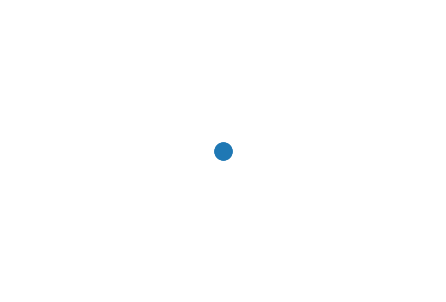

In [3]:
nx.draw_spectral(G)

# Problem Parameters

In [4]:
theta = np.array([[-2,1],[-2,1]])
xi = 5

# Loss and Gradient Oracles

In [5]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):
    return 2*np.dot(theta,x) + xi

# Centralized GD

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 75473.77it/s]


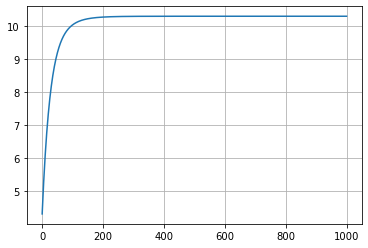

In [6]:
x = np.random.rand(n)  # Initialize prices
step = 1e-2  # Step size
rev = []
x_hist = []
iterations = 1000

# Run centralized GD
for i in trange(iterations):
    rev.append(total_revenue(x,theta,xi))
    x_hist.append(x.copy())
    x += step*grad_revenue(x,theta,xi)
    
    
plt.figure()
plt.plot(rev)
plt.grid()
plt.show()

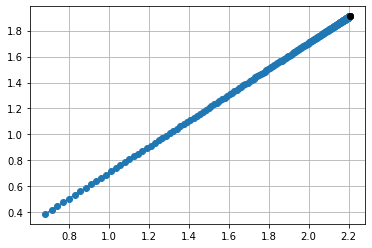

In [7]:
x_hist = np.array(x_hist)
plt.figure()
plt.plot(x_hist[:,0],x_hist[:,1],'-o')
plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
plt.grid()
plt.show()

# Distributed SGD with synchronous information